<a href="https://colab.research.google.com/github/Evans2424/IACEC_Project_Model_Performance_Analysis/blob/main/IACEC_MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis and Predictive Modeling for Liver Disease Diagnosis in Patients

In [77]:
!pip install openml
import openml

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(1480)

# Get dataset by name
dataset = openml.datasets.get_dataset('ilpd')

# Get the data itself as a dataframe (or otherwise)
data, target, _, _ = dataset.get_data(dataset_format="dataframe")

## Data Preprocessing


In [78]:
import pandas as pd
liver_df = pd.DataFrame(data)

# Check the dataframe records and columns
print(liver_df.head())
print(liver_df.columns)

   V1      V2    V3   V4     V5    V6     V7   V8   V9   V10 Class
0  65  Female   0.7  0.1  187.0  16.0   18.0  6.8  3.3  0.90     1
1  62    Male  10.9  5.5  699.0  64.0  100.0  7.5  3.2  0.74     1
2  62    Male   7.3  4.1  490.0  60.0   68.0  7.0  3.3  0.89     1
3  58    Male   1.0  0.4  182.0  14.0   20.0  6.8  3.4  1.00     1
4  72    Male   3.9  2.0  195.0  27.0   59.0  7.3  2.4  0.40     1
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Class'], dtype='object')


In [79]:
# Rename the columns into meaningful names
new_column_names = {
    'V1': 'Age',
    'V2': 'Gender',
    'V3': 'Total Bilirubin',
    'V4': 'Direct Bilirubin',
    'V5': 'Phosphatase',
    'V6': 'Sgpt',
    'V7': 'Sgot',
    'V8': 'Total Proteins',
    'V9': 'Albumin',
    'V10': 'A/G Ratio'
}

# Rename the columns of the DataFrame
liver_df = liver_df.rename(columns=new_column_names)

# Print the first few rows to check the changes
liver_df.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [80]:
# Changed the class values from 1 and 2 to 0 and 1 to make it more sense
print(liver_df['Class'].unique())
liver_df['Class'] = liver_df['Class'].replace({'1': 0, '2': 1}).astype(int)
print(liver_df['Class'].unique())
liver_df['Class'].value_counts()

['1', '2']
Categories (2, object): ['1' < '2']
[0 1]


<ipython-input-80-fb88fb1052d2>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liver_df['Class'] = liver_df['Class'].replace({'1': 0, '2': 1}).astype(int)
<ipython-input-80-fb88fb1052d2>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  liver_df['Class'] = liver_df['Class'].replace({'1': 0, '2': 1}).astype(int)


In [81]:
# Describe the dataset
liver_df.describe()

,Age,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,0.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.318492,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.947064,0.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


In [82]:
# Information about the dataset
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               583 non-null    uint8   
 1   Gender            583 non-null    category
 2   Total Bilirubin   583 non-null    float64 
 3   Direct Bilirubin  583 non-null    float64 
 4   Phosphatase       583 non-null    float64 
 5   Sgpt              583 non-null    float64 
 6   Sgot              583 non-null    float64 
 7   Total Proteins    583 non-null    float64 
 8   Albumin           583 non-null    float64 
 9   A/G Ratio         583 non-null    float64 
 10  Class             583 non-null    int64   
dtypes: category(1), float64(8), int64(1), uint8(1)
memory usage: 42.4 KB


In [83]:
# Checking if there is null values or not
liver_df.isnull()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
578,False,False,False,False,False,False,False,False,False,False,False
579,False,False,False,False,False,False,False,False,False,False,False
580,False,False,False,False,False,False,False,False,False,False,False
581,False,False,False,False,False,False,False,False,False,False,False


In [84]:
# Checking if there is null values or not
liver_df.isnull().sum()

,0
Age,0
Gender,0
Total Bilirubin,0
Direct Bilirubin,0
Phosphatase,0
Sgpt,0
Sgot,0
Total Proteins,0
Albumin,0
A/G Ratio,0


## Data exploration/visualization

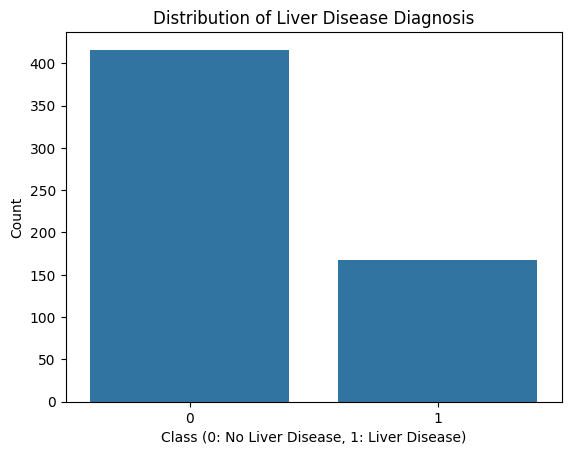

Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=liver_df, x='Class')
plt.title('Distribution of Liver Disease Diagnosis')
plt.xlabel('Class (0: No Liver Disease, 1: Liver Disease)')
plt.ylabel('Count')
plt.show()

# Count the number of patients diagnosed with liver disease and those not diagnosed
LD, NLD = liver_df['Class'].value_counts()
print('Number of patients diagnosed with liver disease: ', LD)
print('Number of patients not diagnosed with liver disease: ', NLD)